# Previsão de preço de notebook

O uso de machine learning no desafio de previsão de preço de notebooks tem como objetivo principal criar modelos capazes de analisar grandes volumes de dados históricos de preços, especificações técnicas e tendências de mercado. A partir disso, o modelo pode identificar padrões e variáveis que influenciam o preço, como marca, processador, memória, armazenamento e demanda. Com essas informações, o sistema pode prever o preço de um notebook com base nas suas características específicas, ajudando empresas a ajustar estratégias de precificação e consumidores a tomar decisões mais informadas.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle


# tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import FunctionTransformer
import scipy.stats as st 


# models
from sklearn.linear_model import  ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# plot
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

In [2]:
models = ['Elastic Net', 'KNeighbors Regressor',
          'Random Forest Regressor',
          'Gradient Boosting Regressor', 
          'XGB Regressor']


# Path to local folder
# path_data = r'D:\OneDrive\DEV\Dados_Estatistica\Model_Notebook_price'

# Ensure the directory exists
output_dir = 'Model_Notebook_price'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# sep = r'/'

In [3]:
df = pd.read_csv("laptop_data.csv")
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [4]:
print(df.shape)

(1303, 12)


In [5]:
print(df.isnull().sum())

Unnamed: 0          0
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64


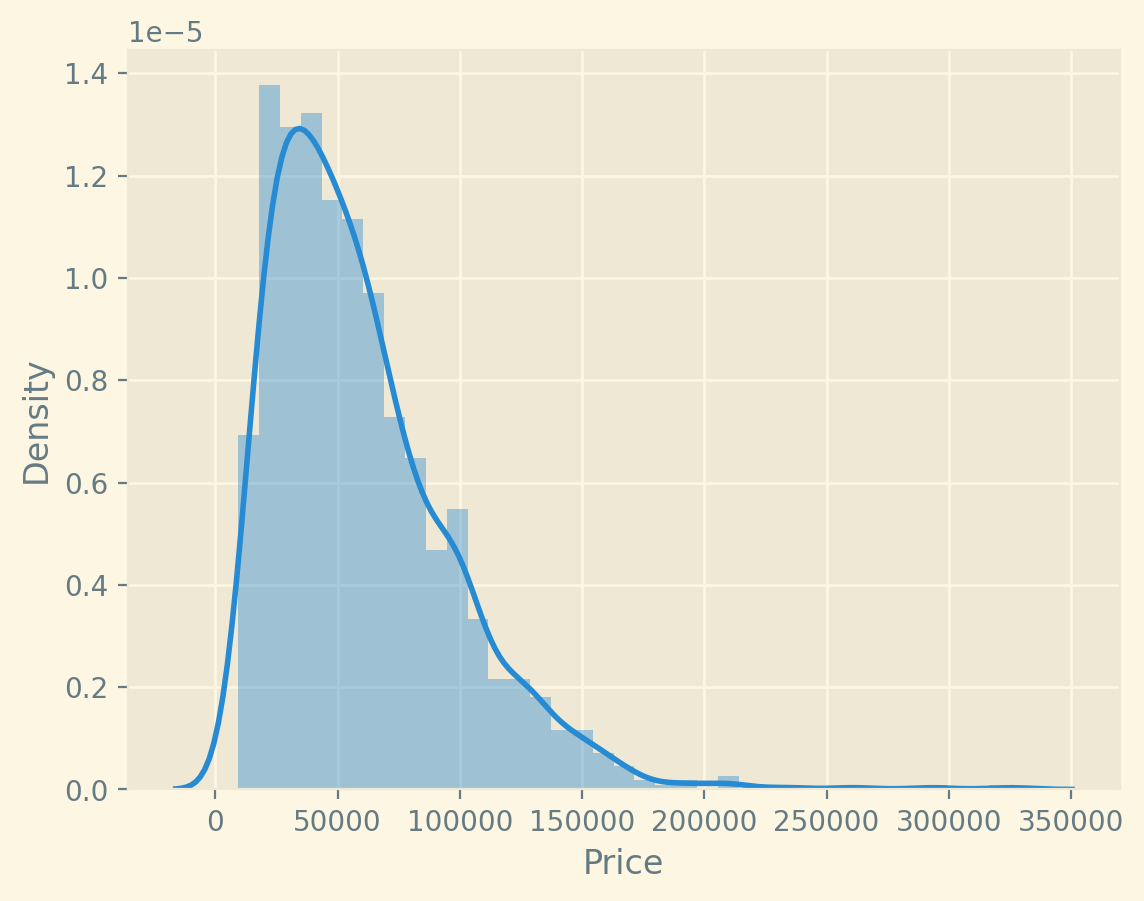

In [6]:
sns.distplot(df['Price'])
plt.show()

## Engenharia de dados

Adotou-se os seguintes procedimento 

- Remoção de colunas desnecessárias:
    - Realização da exclusão da coluna 'Unnamed: 0', possivelmente um índice auxiliar.

- Limpeza dos dados:
    - Remoção de caracteres não numéricos das colunas RAM e Peso e conversão para o tipo float.

- Divisão da coluna 'Memory':
    - Divisão da coluna 'Memory' em duas partes com base no sinal '+' e manutenção apenas da parte relevante.
    - Criação da coluna value_ram com os valores numéricos de memória.

- Padronização dos sistemas operacionais:
    - Agrupamento das variantes de Windows como 'Windows', Mac como 'Mac', e classificação dos outros sistemas como 'Other'.

- Criação da coluna 'Touchscreen':
    - Criação de uma coluna binária indicando a presença ou ausência de tela sensível ao toque.

- Extração da resolução X:
    - Extração do valor da resolução X e remoção da coluna original de resolução.

- Padronização dos processadores (CPU):
   - Padronização dos processadores como i3, i5, i7, AMD, entre outros.
   - Exclusão de linhas com valores atípicos de processador.

- Criação da coluna 'gpu_company':
    - Identificação e agrupamento das empresas de GPU (Intel, AMD, Nvidia) em uma nova coluna.

- Limpeza da coluna 'Gpu':
    - Remoção de caracteres não numéricos e conversão dos valores de GPU para float.
    - Preenchimento de valores ausentes de GPU com zero.

In [7]:
# Drop the 'Unnamed: 0' column from the DataFrame, as it's likely an unnecessary index or auxiliary column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Remove non-digit characters from the 'Ram' column and convert it to float type
df['Ram'] = df['Ram'].str.replace(r'\D', '', regex=True).astype(float)

# Remove non-digit characters from the 'Weight' column and convert it to float type
df['Weight'] = df['Weight'].str.replace(r'\D', '', regex=True).astype(float)

# Split the 'Memory' column into two parts based on the '+' sign and create two new columns: 'memory_part1' and 'memory_part2'
df[['memory_part1', 'memory_part2']] = df['Memory'].str.split('+', expand=True)

# Drop the original 'Memory' column and 'memory_part2' since it's no longer needed
df.drop(columns=['Memory'], inplace=True)
df.drop(columns=['memory_part2'], inplace=True)

# Extract the numerical value from 'memory_part1' (removing non-digit characters) and store it in 'value_ram' column
df['value_ram'] = df['memory_part1'].str.replace(r'\D', '', regex=True).astype(float)

# Clean 'memory_part1' by removing 'GB' and 'TB' units and keeping only the type of memory (HDD, SSD, etc.)
df['memory_part1'] = df['memory_part1'].str.replace('GB', '')
df['memory_part1'] = df['memory_part1'].str.replace('TB', '')
df['memory_part1'] = df['memory_part1'].str.replace(r'\d', '', regex=True)

# Standardize the 'OpSys' column by classifying all systems containing 'Windows' as 'Windows', 'Mac' as 'Mac', and others as 'Other'
df.loc[df['OpSys'].str.contains('Windows', case=False, na=False), 'OpSys'] = 'Windows'
df.loc[df['OpSys'].str.contains('mac*', case=False, na=False), 'OpSys'] = 'Mac'
df.loc[~df['OpSys'].str.contains('Windows|Mac', case=False, na=False), 'OpSys'] = 'Other'

# Create a binary 'Touchscreen' column: 1 if 'ScreenResolution' contains 'Touchscreen', otherwise 0
df['Touchscreen'] = df['ScreenResolution'].str.contains('Touchscreen', case=False, na=False).astype(int)

# Define a function to extract the X-resolution (first part of the resolution) from the 'ScreenResolution' column
def findXresolution(s):
  return s.split()[-1].split("x")[0]

# Apply the 'findXresolution' function to create the 'X_res' column and convert it to integer
df['X_res'] = df['ScreenResolution'].apply(lambda x: findXresolution(x))
df['X_res'] = df['X_res'].astype('int')

# Drop the original 'ScreenResolution' column as it is no longer needed
df.drop(columns=['ScreenResolution'], inplace=True)

# Extract the CPU clock speed in GHz from the 'Cpu' column, remove 'GHz' string, and convert to float type
df['GHz'] = df['Cpu'].str.extract(r'(\d+\.\d+GHz)')
df['GHz'] = df['GHz'].str.replace('GHz', '').astype(float)

# Fill missing values in 'GHz' column with 0
df['GHz'].fillna(0, inplace=True)

# Standardize CPU types: replace occurrences of 'i3', 'i5', 'i7', 'AMD', 'Celeron', and 'Intel' with their respective values
df.loc[df['Cpu'].str.contains('i3', case=False, na=False), 'Cpu'] = 'i3'
df.loc[df['Cpu'].str.contains('i5', case=False, na=False), 'Cpu'] = 'i5'
df.loc[df['Cpu'].str.contains('i7', case=False, na=False), 'Cpu'] = 'i7'
df.loc[df['Cpu'].str.contains('AMD', case=False, na=False), 'Cpu'] = 'AMD'
df.loc[df['Cpu'].str.contains('celeron', case=False, na=False), 'Cpu'] = 'celeron'
df.loc[df['Cpu'].str.contains('intel', case=False, na=False), 'Cpu'] = 'intel'

# Remove a specific outlier row with an invalid CPU value 'Samsung Cortex A72&A53 2.0GHz'
df = df[df['Cpu'] != 'Samsung Cortex A72&A53 2.0GHz']

# Initialize a new column 'gpu_company' with default value 'Unknown'
df['gpu_company'] = 'Unknown'

# Classify 'Gpu' brands and assign values: 'Intel', 'AMD', 'Nvidia' depending on the content of the 'Gpu' column
df.loc[df['Gpu'].str.contains('Intel', case=False, na=False), 'gpu_company'] = 'Intel'
df.loc[df['Gpu'].str.contains('AMD', case=False, na=False), 'gpu_company'] = 'AMD'
df.loc[df['Gpu'].str.contains('Nvidia', case=False, na=False), 'gpu_company'] = 'Nvidia'

# Clean the 'Gpu' column by removing non-digit characters and retaining only numeric parts
df['Gpu'] = df['Gpu'].str.replace(r'\D', '', regex=True)

# Replace any empty strings in the 'Gpu' column with NaN values
df['Gpu'].replace('', np.nan, inplace=True)

# Convert 'Gpu' column to float type and fill NaN values with 0
df['Gpu'] = df['Gpu'].astype(float)
df['Gpu'].fillna(0, inplace=True)

df

,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price,memory_part1,value_ram,Touchscreen,X_res,GHz,gpu_company
0,Apple,Ultrabook,13.3,i5,8.0,640.0,Mac,137.0,71378.6832,SSD,128.0,0,2560,2.3,Intel
1,Apple,Ultrabook,13.3,i5,8.0,6000.0,Mac,134.0,47895.5232,Flash Storage,128.0,0,1440,1.8,Intel
2,HP,Notebook,15.6,i5,8.0,620.0,Other,186.0,30636.0000,SSD,256.0,0,1920,2.5,Intel
3,Apple,Ultrabook,15.4,i7,16.0,455.0,Mac,183.0,135195.3360,SSD,512.0,0,2880,2.7,AMD
4,Apple,Ultrabook,13.3,i5,8.0,650.0,Mac,137.0,96095.8080,SSD,256.0,0,2560,3.1,Intel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,i7,4.0,520.0,Windows,18.0,33992.6400,SSD,128.0,1,1920,2.5,Intel
1299,Lenovo,2 in 1 Convertible,13.3,i7,16.0,520.0,Windows,13.0,79866.7200,SSD,512.0,1,3200,2.5,Intel
1300,Lenovo,Notebook,14.0,celeron,2.0,0.0,Windows,15.0,12201.1200,Flash Storage,64.0,0,1366,1.6,Intel
1301,HP,Notebook,15.6,i7,6.0,5330.0,Windows,219.0,40705.9200,HDD,1.0,0,1366,2.5,AMD


Para comparar os modelos regressivos, foram utilizados:

- Erro Absoluto Médio (EAM)
- Raiz do Erro Quadrático Médio (REQM)
- Correlação


In [8]:
def fun_metrics(y_test, y_pred, metricas, model):
    # Calculate the Mean Absolute Error (RMAE) between the actual values (y_test) and the predictions (y_pred)
    rmae = round(mean_absolute_error(y_test, y_pred), 3),
    
    # Calculate the Root Mean Squared Error (RMSE) between the actual values (y_test) and the predictions (y_pred)
    rmse = round(root_mean_squared_error(y_test, y_pred), 3),
    
    # Calculate the coefficient of determination (R²) between the actual values (y_test) and the predictions (y_pred)
    r2 = round(r2_score(y_test, y_pred), 3)

    # Create a dictionary with the calculated metrics and the model name
    met = {'Model': model,
           'RMAE': rmae,
           'RMSE': rmse,
           'R²': r2}
    
    # Convert the dictionary into a pandas DataFrame
    metrica = pd.DataFrame(data=met)
    
    # Concatenate the metrics DataFrame with the existing metrics DataFrame (metricas)
    metricas = pd.concat([metrica, metricas])
    
    # Return the updated DataFrame of metrics
    return metricas


In [9]:
# Set a random seed for reproducibility
seed = 1612
np.random.seed(seed)

def func_models(df, models):
    best_params = []  # Initialize a list to store best parameters for each model
    metricas = pd.DataFrame()  # Initialize an empty DataFrame for metrics

    # Separate features and target variable from the DataFrame
    X = df.drop(columns=['Price'])  # Features
    y = np.log(df['Price'])  # Log-transform the target variable to normalize it

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

    # Define categorical columns for preprocessing
    categorical_columns = ['Company', 'TypeName', 'OpSys', 'memory_part1', 'gpu_company']
        
    # Preprocessor for numeric and categorical columns using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),  # One-hot encode categorical variables
            ('num', FunctionTransformer(lambda x: x.astype(float)), make_column_selector(dtype_include='number'))  # Convert numeric columns to float
        ]
    )
    
    # Fit the preprocessor and transform the training and test sets
    X_train_preprocessed = preprocessor.fit_transform(X_train)  # Fit and transform training data
    X_test_preprocessed = preprocessor.transform(X_test)  # Transform test data

    # Loop through each model in the models list
    for model in models:      
        if model == 'Elastic Net':
            model_name = 'ElasticNet'
            # Define parameter grid for Elastic Net
            params = {
                "alpha": st.uniform(0.01, 1),  # Regularization strength
                "l1_ratio": st.uniform(0, 1)  # Mix ratio for L1 and L2 penalties
            }
            elastic_model = ElasticNet()  # Initialize Elastic Net model
            random_search = RandomizedSearchCV(elastic_model, params, n_iter=10, cv=5)  # Perform random search for hyperparameter tuning
            random_search.fit(X_train_preprocessed, y_train)  # Fit model to training data
            model = ElasticNet(**random_search.best_params_)  # Create model with best parameters
            best_params.append(random_search.best_params_)  # Store best parameters

        elif model == 'KNeighbors Regressor':
            model_name = 'KNeighborsRegressor'
            # Define parameter grid for KNeighbors Regressor
            params = {
                "n_neighbors": st.randint(2, 30),  # Number of neighbors
                "weights": ['uniform', 'distance']  # Weighting function
            }
            knn_model = KNeighborsRegressor()  # Initialize KNeighbors Regressor model
            random_search = RandomizedSearchCV(knn_model, params, n_iter=10, cv=5)  # Perform random search
            random_search.fit(X_train_preprocessed, y_train)  # Fit model to training data
            model = KNeighborsRegressor(**random_search.best_params_)  # Create model with best parameters
            best_params.append(random_search.best_params_)  # Store best parameters

        elif model == 'Random Forest Regressor':
            model_name = 'RandomForestRegressor'
            # Define parameter grid for Random Forest Regressor
            params = {
                "n_estimators": st.randint(10, 200),  # Number of trees in the forest
                "max_depth": st.randint(2, 20),  # Maximum depth of the trees
                "min_samples_split": st.randint(2, 20),  # Minimum samples required to split an internal node
                "min_samples_leaf": st.randint(1, 20)  # Minimum samples required to be at a leaf node
            }
            rf_model = RandomForestRegressor()  # Initialize Random Forest model
            random_search = RandomizedSearchCV(rf_model, params, n_iter=10, cv=5)  # Perform random search
            random_search.fit(X_train_preprocessed, y_train)  # Fit model to training data
            model = RandomForestRegressor(**random_search.best_params_)  # Create model with best parameters
            best_params.append(random_search.best_params_)  # Store best parameters

        elif model == 'Gradient Boosting Regressor':
            model_name = 'GradientBoostingRegressor'
            # Define parameter grid for Gradient Boosting Regressor
            params = {
                "n_estimators": st.randint(50, 200),  # Number of boosting stages to be run
                "learning_rate": st.uniform(0.01, 0.3),  # Step size shrinkage
                "max_depth": st.randint(3, 20)  # Maximum depth of the individual estimators
            }
            gbr_model = GradientBoostingRegressor()  # Initialize Gradient Boosting model
            random_search = RandomizedSearchCV(gbr_model, params, n_iter=10, cv=5)  # Perform random search
            random_search.fit(X_train_preprocessed, y_train)  # Fit model to training data
            model = GradientBoostingRegressor(**random_search.best_params_)  # Create model with best parameters
            best_params.append(random_search.best_params_)  # Store best parameters

        elif model == 'XGB Regressor':
            model_name = 'XGBRegressor'
            # Define parameter grid for XGB Regressor
            params = {
                "n_estimators": st.randint(3, 50),  # Number of trees to fit
                "learning_rate": st.uniform(0.05, 1)  # Learning rate
            }
            xgbr_model = XGBRegressor()  # Initialize XGBoost model
            random_search = RandomizedSearchCV(xgbr_model, params, n_iter=10, cv=5)  # Perform random search
            random_search.fit(X_train_preprocessed, y_train)  # Fit model to training data
            model = XGBRegressor(**random_search.best_params_)  # Create model with best parameters
            best_params.append(random_search.best_params_)  # Store best parameters

        # Check if the model is not None before fitting
        if model is not None:
            model.fit(X_train_preprocessed, y_train)  # Fit the model on preprocessed training data

            # Save the model to a file using model_name
            pickle.dump(model, open(f'{output_dir}/{model_name}.dat', 'wb'))  # Save the model to a .dat file

            # Predict and calculate metrics
            y_pred = model.predict(X_test_preprocessed)  # Make predictions on the test set
            # y_pred = np.exp(y_pred)  # Uncomment if inverse log transformation is needed
            metricas = fun_metrics(y_test, y_pred, metricas, model_name)  # Calculate metrics using fun_metrics
        else:
            print(f"Model '{model}' is not recognized. Skipping...")  # Print message if model is not recognized
    
    return metricas, best_params  # Return the DataFrame of metrics and the list of best parameters


In [10]:
metricas, best_params =  func_models(df, models)

O modelo recomendado seria o Gradiente Boosting

In [11]:
metricas


,Modelo,RMAE,RMSE,R²
0,XGBRegressor,0.159,0.222,0.883
0,GradientBoostingRegressor,0.158,0.212,0.893
0,RandomForestRegressor,0.170,0.229,0.875
0,KNeighborsRegressor,0.223,0.301,0.783
0,ElasticNet,0.281,0.358,0.694
